In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

try:
    import pandas_datareader.data as web
    import cvxpy as cp
except:
    %pip install pip pandas-datareader
    %pip install pip cvxpy
    import pandas_datareader.data as web
    import cvxpy as cp
  

In [36]:
def Asset(ticker , start, end):
    return(web.get_data_yahoo(ticker, start, end)['Adj Close'])

In [37]:
data = Asset(['AAPL','GOOGL', 'MSFT', 'AMZN'], '2011-01-01', '2021-12-31')
ret = data.pct_change().dropna()

mu = ret.mean() *12 
mu = pd.DataFrame(mu)
sigma = ret.cov() *12

asset_num = ret.shape[1]


In [38]:
def get_pfo_var(weights):
    return np.dot(weights.T, np.dot(sigma, weights))

#x0 = np.ones(asset_num)/asset_num
x0 = [1/5, 1/5, 1/5, 2/5]
constraints = ({"type": "eq", "fun": lambda x: np.sum(x)-1})

In [39]:
gmv = minimize(get_pfo_var, x0, method = 'SLSQP', constraints = constraints,
               bounds=((0,1),)*asset_num)

gmv.x

array([0.28198726, 0.28771429, 0.31396789, 0.11633056])

GMV by Cvxpy

In [41]:
gmv2 = cp.Variable(asset_num)
objective = cp.Minimize(cp.quad_form(gmv2, sigma))
constraints = [cp.sum(gmv2)==1]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS)

gmv2.value

array([0.23460095, 0.32090512, 0.33400755, 0.11048639])

Efficient Portfolio

In [42]:
ret_gmv = mu.transpose().dot(gmv2.value)
ret_target = np.round(ret_gmv,3) +0.002

mu = pd.DataFrame(mu)

In [44]:
w = cp.Variable(asset_num)
objective = cp.Minimize(cp.quad_form(w, sigma))
constraints = [cp.sum(w)==1, w>=0, w@mu >=ret_target]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS)

w.value


In [9]:
mu.transpose().dot(w.value)

0    0.015
dtype: float64

Efficient Frontier

In [48]:
trets = np.linspace(ret_gmv, mu.max(), 30)
tvols = []
for tret in trets:
    w = cp.Variable(asset_num)
    objective = cp.Minimize(cp.quad_form(w, sigma))
    constraints = [cp.sum(w)==1, w>=0, w@mu >= tret]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS)
    tvols.append(np.sqrt(np.dot(w.value.T, np.dot(sigma, w.value))))


tvols

[0.048068236552620366,
 0.048076228215600425,
 0.04810019709756236,
 0.0481401155355049,
 0.048195946496446936,
 0.048267635110485776,
 0.04835511009800642,
 0.04845828563996907,
 0.048577062216397925,
 0.0487113261422635,
 0.048860948892466956,
 0.04902579015970455,
 0.04920569654412019,
 0.049400503966431,
 0.04961003641536271,
 0.049834108620928734,
 0.05007252655011479,
 0.05033090319866819,
 0.05066314300003134,
 0.05108100544120237,
 0.051582409918223715,
 0.052164947478895454,
 0.05282593436680881,
 0.05356246444957306,
 0.05437147136338023,
 0.055274727679069824,
 0.05697210535319212,
 0.05970403201385877,
 0.0633367780527693,
 0.0677255392818476]

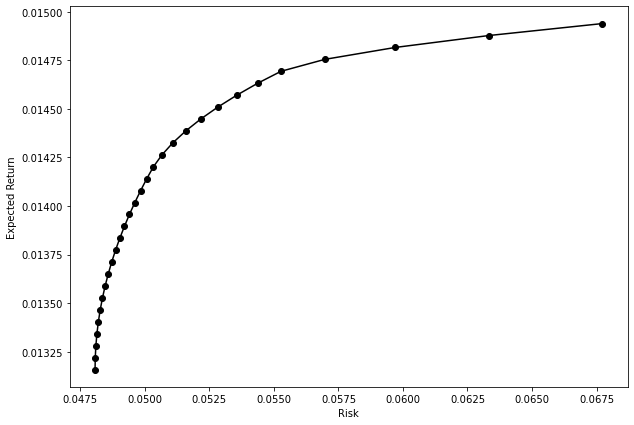

In [50]:
plt.figure(figsize = (10,7))
plt.plot(tvols, trets, '-ok')
plt.xlabel("Risk")
plt.ylabel("Expected Return")
plt.show()

Lasso Regularization

In [60]:
lams = np.linspace(0, 0.01, 100)
w_s = []

for lam in lams:
    w = cp.Variable(asset_num)
    objective = cp.Minimize(cp.quad_form(w, sigma)+ lam*cp.norm(w, 1))
    constraints = [cp.sum(w)==1]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS)
    w_s.append(w.value)



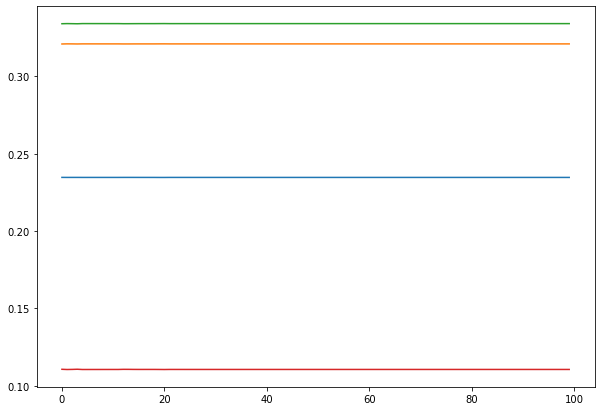

In [54]:
plt.figure(figsize = (10, 7))
plt.plot(w_s)
plt.show()